In [1]:
from datetime import datetime
import folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import Point, LineString
from geographiclib.geodesic import Geodesic
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyffp import calc_footprint_FFP as myfootprint
from pyffp import calc_footprint_FFP_climatology as myfootprintclim

from pyffp.utils import get_dd
from pyffp.utils import contour_to_gdf
import geopy
from geopy.distance import geodesic

plt.style.use('dark_background')

In [2]:
def read_l3(filepath, datecol='DATE'):
    df = (pd.read_csv(filepath, header=0, low_memory=False)
      .replace(-9999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x[datecol]))
      .set_index('date')
     )
    df.index = df.index.set_names(None)
    return df

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25.csv'

l3 = read_l3(filepath)

predictors = 'baseflux'

filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'

rf = read_l3(filepath).add_suffix('_RF')

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L1_fluxnet_2023-04-10.csv'
l1_fluxnet = read_l3(filepath)

l3['V_SIGMA'] = l1_fluxnet.loc[l1_fluxnet.index == l3.index, 'V_SIGMA']

l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':]], axis=1)

soil_dateformat = 'yyyy-mm-dd HH:MM:SS+00.00' # from ATMOS484 package

<Axes: >

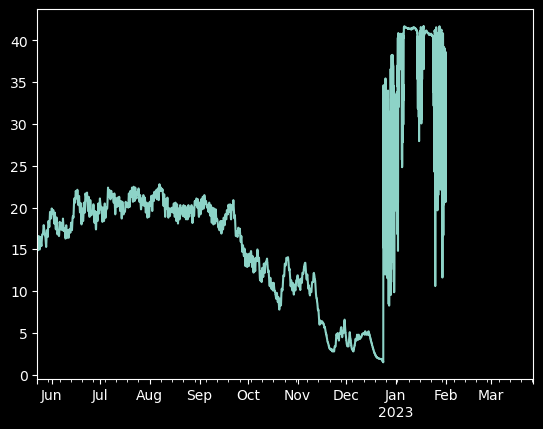

In [3]:
soil = read_l3('/home/otto/data/atmos-flux-data/output/atmos484_20230328_biomet.csv', datecol='date')
soil.loc[:, 'Tsoil_77'].plot()

In [6]:
df = soil.loc['2022-06', :]

In [47]:
soilT = df.loc[:, df.columns.str.match('Tsoil_([0-9]+)([0-9]+)(?!cm)')]
soilT = soilT.melt(var_name='sensor', value_name='Tsoil', ignore_index=False)
locs = soilT.loc[:, 'sensor'].str.extract('Tsoil_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilT = pd.concat([soilT, locs], axis=1)

### Soil sensor grid

Locations of data loggers are taken from Zentra cloud website manually (can be saved to a csv).

Sensor numbers and data loggers read from ATMOS_SoilSensors_layout.xlsx, from Alexis Renchon (uploaded to Google Drive folder "ATMOS Flux Data").

We make a geodataframe of data loggers and find the azimuth of the grid from the logger locations.

<Axes: >

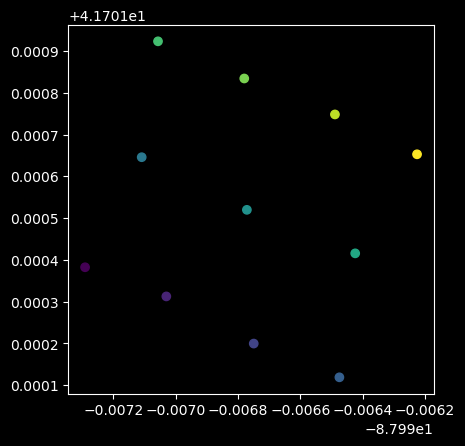

In [12]:
filepath = '/home/otto/data/atmos-flux-data/input/ATMOS_SoilSensors_layout.xlsx - Sheet1.csv'

dataloggers = pd.read_csv(filepath, usecols=[0, 1, 2, 3, 4], header=0, 
                          names=['logger', 'serial', 'status', 'lat', 'lon']).dropna()
dataloggers = gpd.GeoDataFrame(dataloggers, 
                               geometry=gpd.points_from_xy(dataloggers['lon'], dataloggers['lat']),
                               crs=4326)
dataloggers.plot(column='logger')

In [13]:
#Define the ellipsoid
geod = Geodesic.WGS84

B = (dataloggers.geometry[0].x, dataloggers.geometry[0].y) #Point A (lat, lon)
A = (dataloggers.geometry[3].x, dataloggers.geometry[3].y) #Point B (lat, lon)

#Solve the Inverse problem
inv = geod.Inverse(A[0],A[1],B[0],B[1])
azi1 = inv['azi1']
print('Initial Azimuth from A to B = ' + str(azi1))

B = (dataloggers.geometry[7].x, dataloggers.geometry[7].y) #Point A (lat, lon)
A = (dataloggers.geometry[10].x, dataloggers.geometry[10].y) #Point B (lat, lon)


Initial Azimuth from A to B = 179.3531284100548


In [14]:
A = dataloggers.geometry[3]
B = dataloggers.geometry[0]
inv = geod.Inverse(A.y,A.x,B.y,B.x)
azib = inv['azi1']
print('Initial Azimuth from A to B = ' + str(azib))

A = dataloggers.geometry[10]
B = dataloggers.geometry[7]
inv = geod.Inverse(A.y,A.x,B.y,B.x)
azit = inv['azi1']
print('Initial Azimuth from A to B = ' + str(azit))
azi = np.mean([azib, azit])
azi

Initial Azimuth from A to B = -66.67909064882072
Initial Azimuth from A to B = -66.51445741226922


-66.59677403054496

Projecting from center, logger 6

In [15]:
center = dataloggers.geometry[5]

s = 50 - 6.5 # m
direct = geod.Direct(center.y,center.x,azi,s)
leftmidpt = (direct['lat2'],direct['lon2'])

direct = geod.Direct(leftmidpt[0],leftmidpt[1],azi-90,s)
origin = (direct['lat2'],direct['lon2'])
print('Origin = ' + str(origin))

Origin = (41.70131583022141, -87.99745859087017)


Make a geodataframe of soil sensor locations by logger

In [16]:
sensors = pd.read_csv(filepath, usecols=[5, 6, 7, 8, 9, 10, 11], header=0, 
                      names=['logger', 'serial', 'status', 'port', 'teros_num', 'x', 'y'])

cols = ['logger', 'serial', 'status']
sensors.loc[:, cols] = sensors.loc[:, cols].ffill()

sensors = sensors.sort_values(by=['x','y'])

yax = np.array([geod.Direct(origin[0], origin[1], azi+90, s*12.5) for s in range(0, 8)])

xax = np.array([geod.Direct(origin[0], origin[1], azi-180, s*12.5) for s in range(0, 8)])

sensors.loc[sensors['y']==0, 'lat'] = [xax[x]['lat2'] for x in range(8)]
sensors.loc[sensors['y']==0, 'lon'] = [xax[x]['lon2'] for x in range(8)]
sensors.loc[sensors['x']==0, 'lat'] = [yax[y]['lat2'] for y in range(8)]
sensors.loc[sensors['x']==0, 'lon'] = [yax[y]['lon2'] for y in range(8)]

for i in range(1,8):
    row = np.array([geod.Direct(yax[i]['lat2'], yax[i]['lon2'], azi-180, s*12.5) for s in range(0, 8)])
    row
    sensors.loc[sensors['y']==i, 'lat'] = [row[x]['lat2'] for x in range(8)]
    sensors.loc[sensors['y']==i, 'lon'] = [row[x]['lon2'] for x in range(8)]

    
# sensors.loc[:,'zone'] = [0,0,1,1,2,2,3,3,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15,15,12,12,13,13,14,14,15,15]
# sensors.loc[:,'zone'] = [0,0,4,4,8,8,12,12,0,0,4,4,8,8,12,12,1,1,5,5,9,9,13,13,1,1,5,5,9,9,13,13,2,2,6,6,10,10,14,14,2,2,6,6,10,10,14,14,3,3,7,7,11,11,15,15,3,3,7,7,11,11,15,15]
sensors.loc[:, 'zone'] = sensors['x'] // 2 + 4 * (sensors['y'] // 2)


sensors = gpd.GeoDataFrame(sensors, 
                               geometry=gpd.points_from_xy(sensors['lon'], sensors['lat']),
                               crs=4326)

In [94]:
zones = sensors.dissolve(by=['zone'], as_index=False)

zonesm = zones.to_crs(3174)
# zonesm.geometry = zonesm.geometry.convex_hull.buffer(distance=6.25, cap_style=1, quad_segs=1)
zonesm.geometry = zonesm.geometry.convex_hull.apply(lambda g: g.buffer(distance=6.25, cap_style=3, join_style=2))

zones = zonesm.to_crs(4326)

<Axes: >

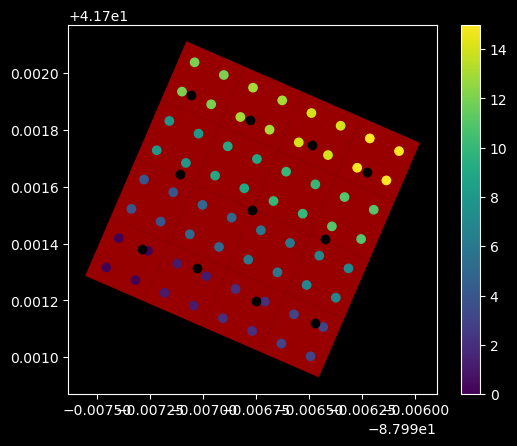

In [95]:
fig, ax = plt.subplots()

zones.plot(color = 'red', alpha = 0.6, ax=ax)

sensors.plot(column = 'zone', cmap='viridis',
             legend=True,
             ax=ax)
dataloggers.plot(color = 'black', ax=ax)

Find datalogger points within a zone

In [96]:
# points_within = gpd.sjoin(dataloggers, soilzones, predicate='within')
points_within = dataloggers.geometry.within(zones.geometry.iloc[2])
points_within

0     False
1     False
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
dtype: bool

### Site parameters

In [43]:
z_tower = 4
hei = 1.5
z0t = 0.15 * hei
d = 0.67 * hei

datestart = '2022-06'
dateend = '2022-06'

df = l3.loc[datestart:dateend]
df = df.loc[df['L'].notna()]

ht = 750 * np.ones(len(df))
ht = ht.tolist()

zmt = (z_tower - d) * np.ones(len(df))
zmt = zmt.tolist()

olt = df['L'].tolist()
sigmavt = df['V_SIGMA'].tolist()
ustart = df['u.'].tolist()
wind_dirt = df['wind_dir'].tolist()
domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 200
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1


Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  882
Calculating footprint  45  of  882
Calculating footprint  89  of  882
Calculating footprint  133  of  882
Calculating footprint  177  of  882
Calculating footprint  221  of  882
Calculating footprint  265  of  882
Calculating footprint  309  of  882
Calculating footprint  353  of  882
Calculating footprint  397  of  882
Calculating footprint  441  of  882
Calculating footprint  485  of  882
Calculating footprint  529  of  882
Calculating footprint  573  of  882
Calculating footprint  617  of  882
Calculating footprint  661  of  882
Calculating footprint  705  of  882
Calculating footprint  749  of  882
Calculating footprint  793  of  882
Calculating footprint  837  of  882
Calculating footprint  881  of  882


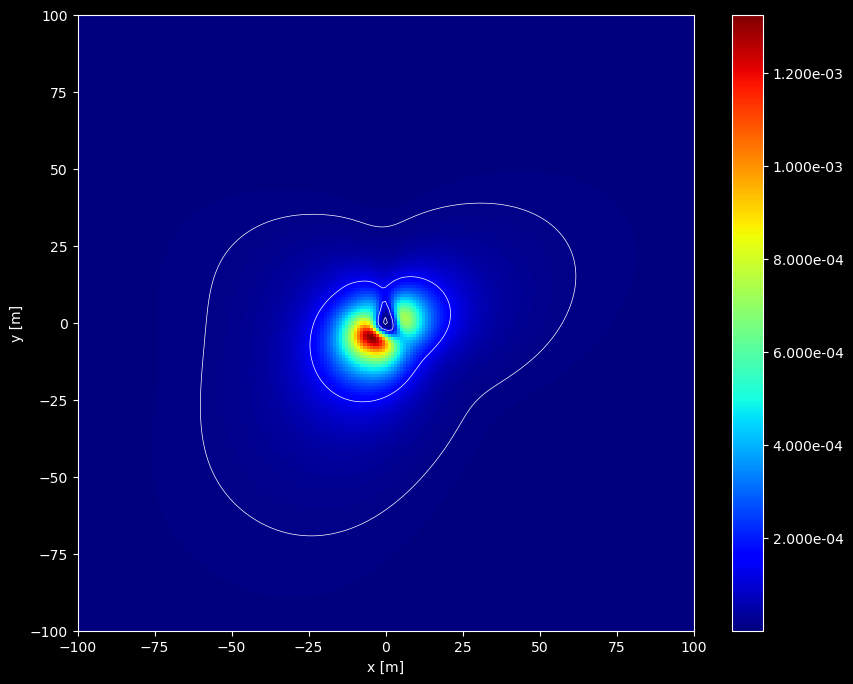

In [44]:
# generate footprints
FFP = myfootprintclim.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1,
    timeseries=True
)

In [45]:
FFP['ftime'].shape

(882, 201, 201)

### Footprint-weighted flux map

For each cell i,j, we multiply the half-hourly flux for half-hour *m* (F_EC*m*) by the half-hourly footprint function for that cell i,j (*f_ijm*), then sum that product for all half-hours. We then divide that sum by the sum of the footprint functions for cell i,j over all half-hours (*f_ijm*).

So, we need to access both the flux and footprint footprint for each half-hour.

In [46]:
ft = FFP['ftime']

# fs = FFP["fclim_2d"]

fv_m = df['FCH4_F_RF'].to_numpy()
fv_c = df['NEE_f'].to_numpy()
fv_w = df['LE_f'].to_numpy()

fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)

/tmp/ipykernel_4304/424981659.py:9: RuntimeWarning: invalid value encountered in divide
  fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
/tmp/ipykernel_4304/424981659.py:10: RuntimeWarning: invalid value encountered in divide
  fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
/tmp/ipykernel_4304/424981659.py:11: RuntimeWarning: invalid value encountered in divide
  fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)


In [47]:
# georeference grids
x_2d = FFP["x_2d"]
y_2d = FFP["y_2d"]
# set the origin at the SE-Nor station
origin_lon = -87.996285
origin_lat = 41.701827
x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

In [68]:
FWFS = gpd.GeoDataFrame(np.ravel(fwfm), columns = ['fm'], 
                        geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
                        crs=4326)
FWFS = FWFS.to_crs(3174)

FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))

FWFS = FWFS.to_crs(4326)

# FTIME = gpd.GeoDataFrame(np.ravel(fwf), columns = ['fm'], 
#                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
#                         crs=4326))

<Axes: >

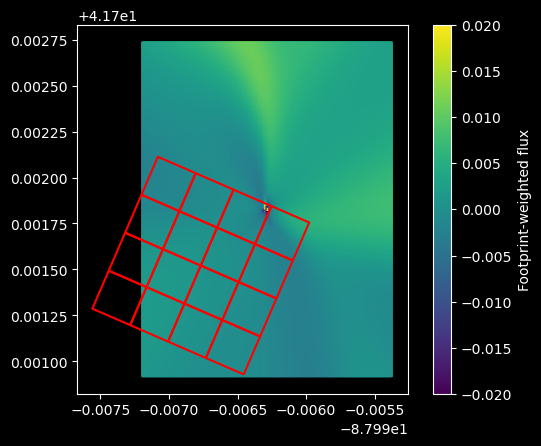

In [98]:
fig, ax = plt.subplots()

FWFS.plot(column='fm', 
          legend = True, 
          vmin = -0.02, 
          vmax = 0.02,
          legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
          ax=ax)

zones.boundary.plot(color = 'red', alpha = 1, ax=ax)

In [49]:
# prepare contour inputs
clevs = FFP["fr"][::-1]
clevs = [clev for clev in clevs if clev is not None]
levs = [clev for clev in clevs]
fs = FFP["fclim_2d"]
cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
f = fs[0]
c = cs[0]
cc = [c]*len(levs)

fwfs = np.sum(df['FCH4_F_RF']) * fs

In [50]:
# generate GeoDataFrame of contours
fig, ax = plt.subplots(figsize=(10, 8))
cp = ax.contour(x_2d_dd, y_2d_dd, fwfc, levs, colors = cc, linewidths=0.5)
gdf = contour_to_gdf(cp)
plt.close()

In [51]:
clevs[::-1]

[0.00014859000322740807, 1.0805554372705176e-05]

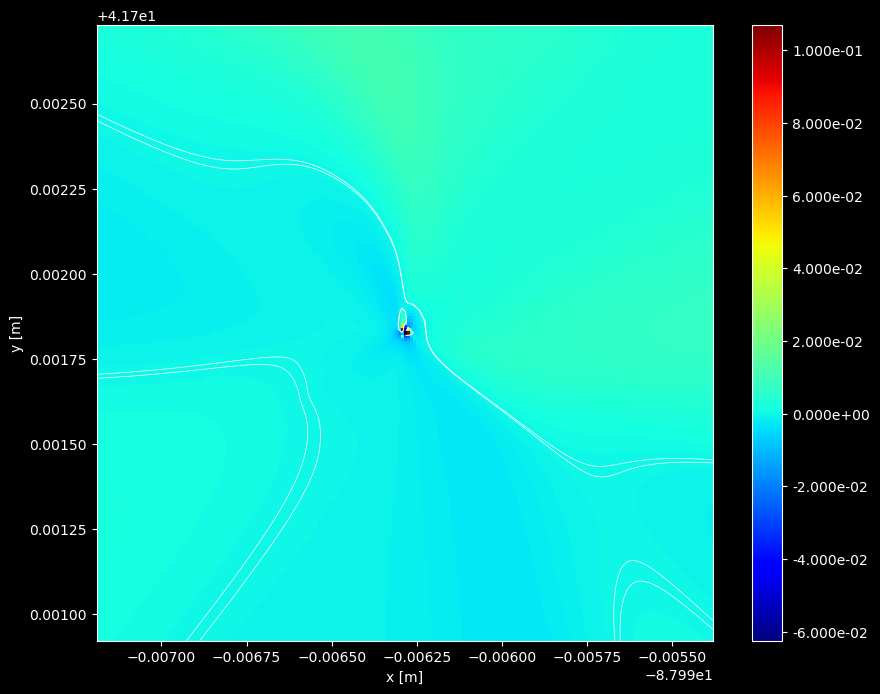

(<Figure size 1000x800 with 2 Axes>, <Axes: xlabel='x [m]', ylabel='y [m]'>)

In [83]:
myfootprintclim.plot_footprint(x_2d=x_2d_dd, y_2d=y_2d_dd, fs=fwfm,
                                        show_heatmap=True,clevs=clevs[::-1])

Sum footprint-weighted fluxes in each zone

<Axes: >

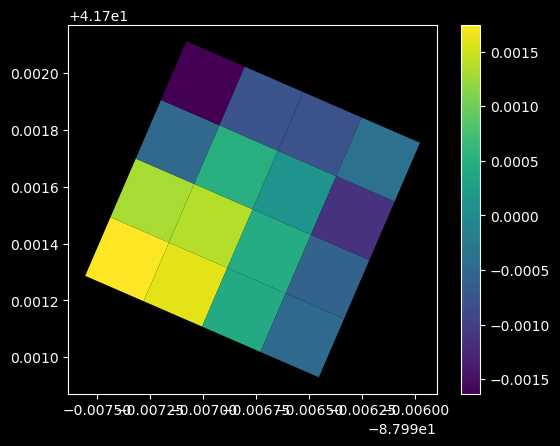

In [97]:
zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]

fig, ax = plt.subplots()
zones.plot(column='fsum_m', legend=True, ax = ax)
# FWFS.plot(column = 'fm', cmap = 'viridis',
#           markersize = 0.001,
#           ax=ax)

In [328]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "ATMOS"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_ffp_esri_{datestart}-{dateend}_{datetime.now().strftime("%Y%m%d")}')
m

In [30]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "ATMOS"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

data = pd.DataFrame({'lat': np.ravel(y_2d_dd),
                     'lon': np.ravel(x_2d_dd),
                     'fwfs': np.ravel(fwfc)})

data = data.loc[data['fwfs'].notna()].to_numpy().tolist()

HeatMap(data).add_to(m)

m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_fwf_esri_{datestart}-{dateend}_{datetime.now().strftime("%Y%m%d")}')
m

In [91]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "SE-Nor"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

map_osm = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
map_osm.add_child(origin)
map_osm.add_child(contours)
map_osm.save('/home/otto/data/atmos-flux-data/output/html/atmos_ffp_osm_2022-06')
map_osm

In [4]:
l3.loc['2022-06-01 09:30', ['FCH4_F_RF']]

FCH4_F_RF    0.088184
Name: 2022-06-01 09:30:00, dtype: object

In [5]:
hh_m = '2022-06-01 09:30'

df = l3.loc[hh_m]

ht = 750

zmt = (z_tower - d)

olt = df['L']
sigmavt = df['V_SIGMA']
ustart = df['u.']
wind_dirt = df['wind_dir']
domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 600
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1

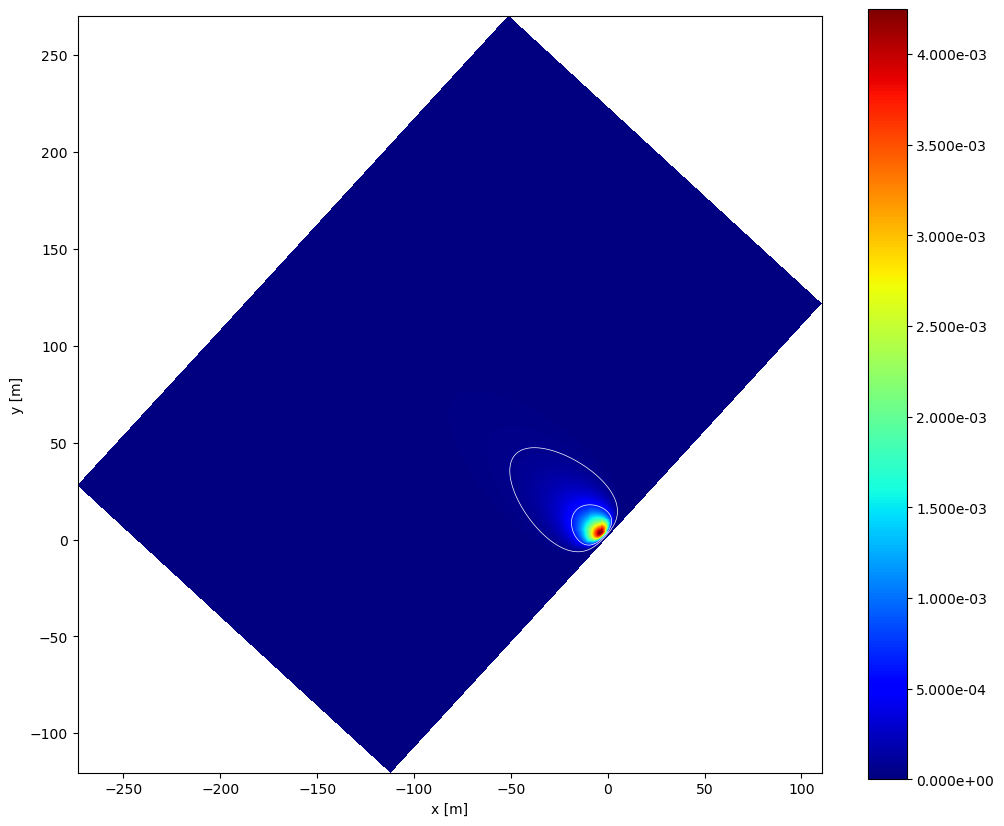

In [6]:
# generate footprints
FFP = myfootprint.FFP(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1
)

In [10]:
datestart = '2022-06'
dateend = '2022-06'

df = l3.loc[datestart:dateend]
df = df.loc[df['L'].notna()]

z_tower = 4
hei = 1.5
z0t = 0.15 * hei
d = 0.67 * hei

ht = 750 * np.ones(len(df))
ht = ht.tolist()

zmt = (z_tower - d) * np.ones(len(df))
zmt = zmt.tolist()

olt = df['L'].tolist()
sigmavt = df['V_SIGMA'].tolist()
ustart = df['u.'].tolist()
wind_dirt = df['wind_dir'].tolist()
domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 200
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1

In [11]:
# generate footprints
FFP = myfootprintclim.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1
)


Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.


AttributeError: 'list' object has no attribute 'shape'

In [3]:
# define footprint inputs
zmt = 20.0
z0t = 0.01
ht = [2000.0, 1800.0, 1500.0]
olt = [-10.0, -100.0, -500.0]
sigmavt = [
    0.9,
    0.7,
    0.3,
]
ustart = [0.5, 0.3, 0.4]
wind_dirt = [30.0, 50.0, 70.0]
domaint = [-100.0, 1000.0, -100.0, 1000.0]
nxt = 1100
rst = [20.0, 40.0, 60.0, 80.0]

In [4]:
# generate footprints
FFP = myfootprintclim.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    smooth_data=1
)


Alert(0017):
 Only one value of zm passed. Using it for all footprints.
 Execution continues.

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  3
Calculating footprint  2  of  3
Calculating footprint  3  of  3


In [21]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
# import seaborn as sns
# import zipfile
# from cycler import cycler
# from FFP_Python import calc_footprint_FFP as myfootprintclim
# import FFP_Python
# from FFP_Python import utils
# from FFP_Python.utils import contour_to_gdf

pd.options.display.float_format = '{:.4f}'.format


# global plotting settings
plt.style.use(['ggplot'])

# default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
#                   cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'axes.labelcolor' : 'black',
                     'yaxis.labellocation' : 'center',
                     'lines.marker' : '.',
                     'lines.linestyle' : 'None',
                     'grid.color' : '.8',
#                      'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (10*1.8, 5.65*1.8)
                    })

# plt.rc('axes', prop_cycle=default_cycler)

data_dir = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/'


# Plot L3 fluxes

## Calculate footprint

In [10]:
df = l3.loc['2022-06-01 11:00']

z_tower = 4
hei = 1.5
z0 = 0.15 * hei
d = 0.67 * hei
h = 750

zm = z_tower - d

ol = df['L']
sigmav = df['V_SIGMA']
ustar = df['u.']

ol

FFP = myfootprintclim.FFP(zm = zm, z0 = z0, h = 750, ol = df['L'], sigmav = df['V_SIGMA'], ustar = df['u.'])

-18.7401

AttributeError: module 'FFP_Python' has no attribute 'utils'

In [18]:
# georeference grids
x_2d = FFP["x_2d"]
y_2d = FFP["y_2d"]
# set the origin at the SE-Nor station
origin_lon = 17.4795
origin_lat = 60.0865
x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

{'x_ci_max': 5.607212151686834,
 'x_ci': array([  1.06797608,   1.26022529,   1.45247451, ..., 192.93269067,
        193.12493989, 193.3171891 ]),
 'f_ci': array([1.27434434e-19, 1.40723523e-09, 2.21419353e-06, ...,
        2.48741212e-04, 2.48258294e-04, 2.47776782e-04]),
 'x_2d': array([[  1.06797608,   1.06797608,   1.06797608, ...,   1.06797608,
           1.06797608,   1.06797608],
        [  1.26022529,   1.26022529,   1.26022529, ...,   1.26022529,
           1.26022529,   1.26022529],
        [  1.45247451,   1.45247451,   1.45247451, ...,   1.45247451,
           1.45247451,   1.45247451],
        ...,
        [192.93269067, 192.93269067, 192.93269067, ..., 192.93269067,
         192.93269067, 192.93269067],
        [193.12493989, 193.12493989, 193.12493989, ..., 193.12493989,
         193.12493989, 193.12493989],
        [193.3171891 , 193.3171891 , 193.3171891 , ..., 193.3171891 ,
         193.3171891 , 193.3171891 ]]),
 'y_2d': array([[-144.18690976, -143.99466055, -143.802

In [145]:
pd.DataFrame(FFP)

ValueError: Per-column arrays must each be 1-dimensional

In [130]:
if None in [zm, 750, [df['L'].values] ]:
    print('yes')

In [138]:
FFP = ffp.FFP(zm = zm, z0 = z0, 
                          h = 750, 
                          ol = ol,
                          sigmav = sigmav,
                          ustar = ustar
                         )

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Annual metrics

In [33]:
l3.loc[:, l3.columns.str.contains('model')]

model
2022-05-24 10:30:00 0.0000
2022-05-24 11:00:00 0.0000
2022-05-24 11:30:00    NaN
2022-05-24 12:00:00    NaN
2022-05-24 12:30:00 0.0000
...                    ...
2023-04-06 09:30:00 0.0000
2023-04-06 10:00:00 0.0000
2023-04-06 10:30:00 0.0000
2023-04-06 11:00:00 0.0000
2023-04-06 11:30:00 0.0000

[15219 rows x 1 columns]

In [6]:
annualmean = l3[['ch4_flux','co2_flux','TA_EP','Precip','T60']].mean(axis=0)
annualmean

ch4_flux     -0.0029
co2_flux     -1.9911
TA_EP        12.5219
Precip        0.1156
T60        1066.9221
dtype: float64

In [7]:
annualsum = l3[['ch4_flux','co2_flux','Precip']].sum(axis=0)
annualsum

ch4_flux      -16.2479
co2_flux   -16503.9427
Precip        810.8000
dtype: float64

In [53]:
cols = ['ch4_flux','FCH4_f', 'FCH4_F_ANN', 'FCH4_F_RF', 'co2_flux', 'NEE_f', 'GPP_f', 'Reco','Precip']
annualsumnorm = l3[cols].sum(axis=0) / l3[cols].notna().sum(axis=0)*2*24*365
annualsumnorm

ch4_flux        -50.9056
FCH4_f          -26.7542
FCH4_F_ANN   -29325.0759
FCH4_F_RF       -20.3210
co2_flux     -34883.4691
NEE_f          -986.3921
GPP_f         96110.1759
Reco          95123.7838
Precip         2025.2660
dtype: float64

In [54]:
# cols = ['FC', 'NEE_f', 'Reco', 'GPP_f', 'FCH4', 'FCH4_f', 'H_f'] # Fluxnet variables
cols = ['co2_flux', 'NEE_f', 'Reco', 'GPP_f', 'ch4_flux', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN', 'LE', 'LE_f','H_f'] # Full output variables

dailysum = l3.loc[:, cols].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
dailysum.loc[:, 'LE_f'] = l3.loc[:, ['LE_f']].groupby(pd.Grouper(freq='1D')).sum()

In [55]:
daily = l3.loc[:, cols].groupby(l3.index.floor('D')).mean()
# daily[['FCH4', 'FCH4_f', 'FCH4_F_ANN']]
# daily.loc[:,'FCH4']
daily

co2_flux   NEE_f   Reco   GPP_f  ch4_flux  FCH4_f  FCH4_F_RF  \
2022-05-24   -5.7456 -6.5086 8.4308 14.9394   -0.0049 -0.0055    -0.0068   
2022-05-25    3.6290  0.6878 8.9215  8.2338   -0.0079 -0.0033    -0.0045   
2022-05-26   -2.8393  0.1329 9.3798  9.2469    0.0093  0.0032     0.0073   
2022-05-27    1.6831  0.1979 8.3872  8.1893   -0.0359 -0.0091    -0.0103   
2022-05-28  -11.5751 -5.2808 8.8048 14.0856   -0.0142 -0.0058    -0.0077   
...              ...     ...    ...     ...       ...     ...        ...   
2023-04-02   -1.3752 -0.3161 3.1527  3.4688   -0.0007 -0.0002    -0.0002   
2023-04-03    2.2016  1.8153 3.8432  2.0280    0.0018  0.0019     0.0000   
2023-04-04    3.7629  2.4669 4.0292  1.5622    0.0056  0.0039     0.0029   
2023-04-05    1.8673  1.7657 4.3560  2.5904   -0.0033 -0.0017    -0.0015   
2023-04-06    0.8177  0.8177 3.0071  2.1894    0.0001  0.0003     0.0003   

            FCH4_F_ANN       LE     LE_f      H_f  
2022-05-24     -1.8061 138.6099 146.4370  70.3890  
2022-05-25     -0.0053  63.8297  81.0091 -11.3800  
2022-05-26      0.0075  87.3695  70.6887 -11.6743  
2022-05-27     -0.0037  67.7102  70.0475  -2.6037  
2022-05-28     -1.5251 189.8657 134.7602  23.8026  
...                ...      ...      ...      ...  
2023-04-02      0.0001  48.5438  36.9962  67.5145  
2023-04-03      0.0014  54.2224  49.2886   8.5554  
2023-04-04     -0.5032  30.5669  31.5251   8.5940  
2023-04-05     -0.0018  54.5584  53.7430 -21.2904  
2023-04-06      0.0004  25.7864  25.7864  29.8501  

[318 rows x 11 columns]

## Plot daily means over half-hours

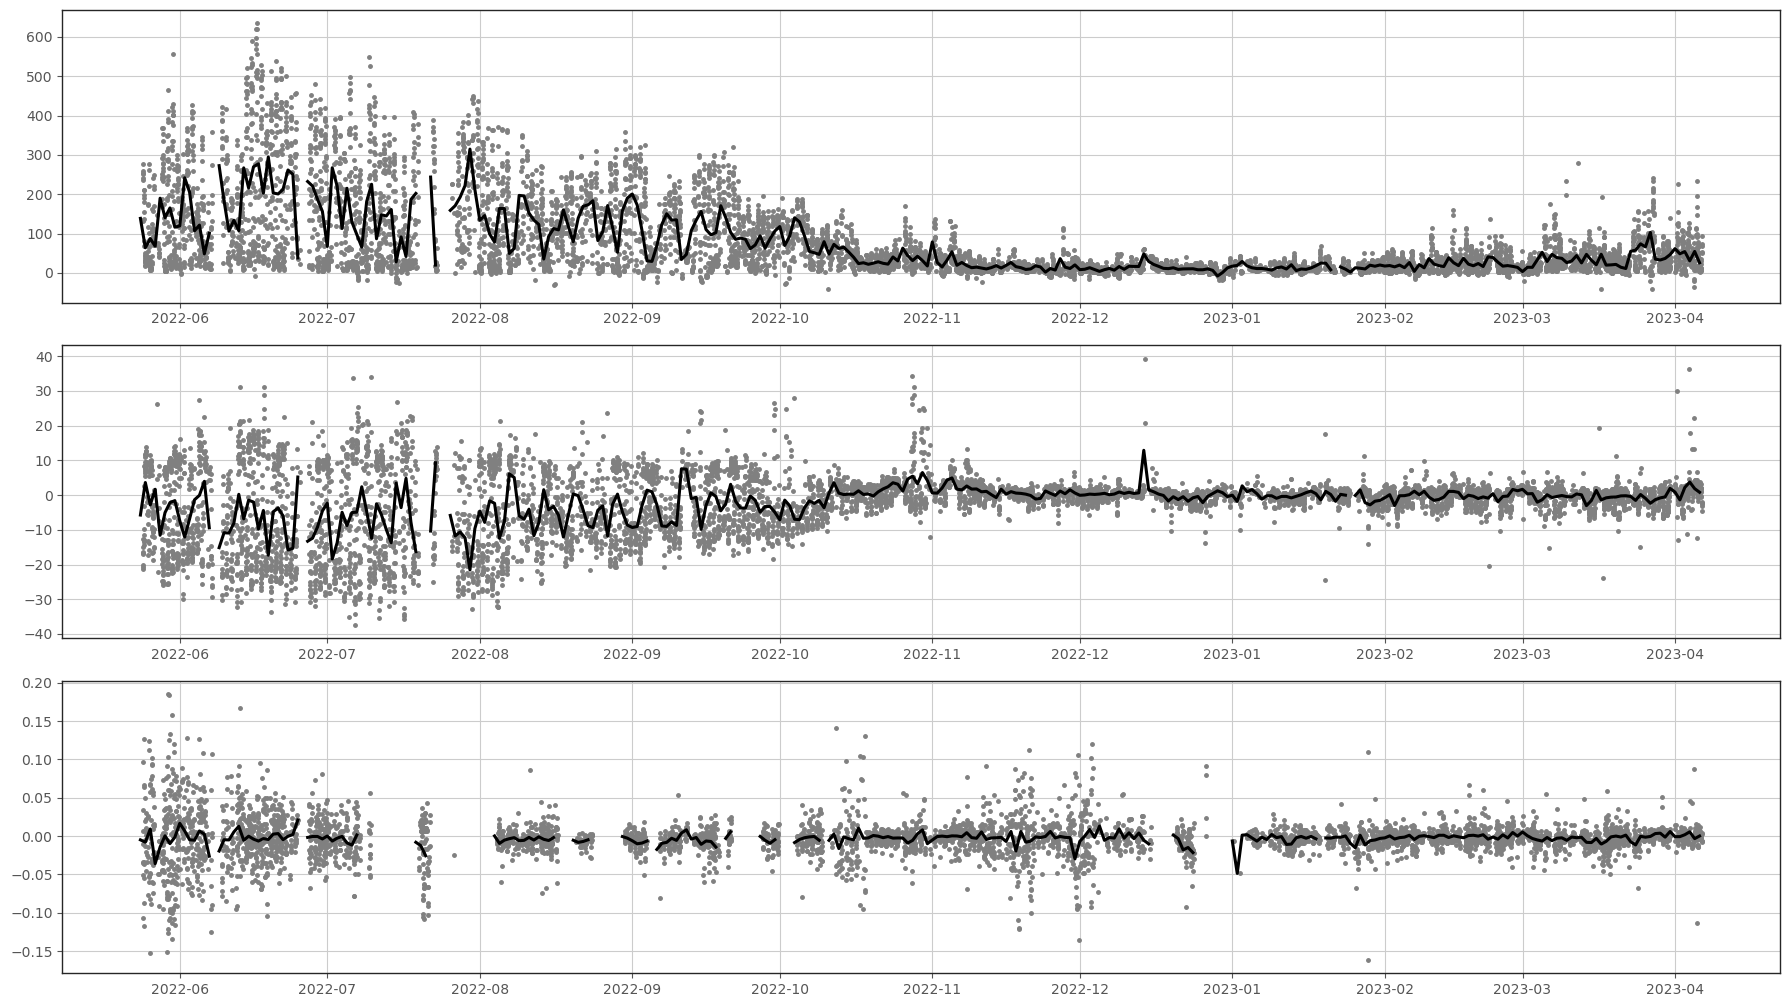

In [56]:
fig, ax = plt.subplots(3,1,figsize=(10*1.8, 5.65*1.8))

ax[0].plot(l3['LE'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[0].plot(daily['LE'], marker = '', lw = 2.2, color = 'k')

ax[1].plot(l3['co2_flux'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[1].plot(daily['co2_flux'], marker = '', lw = 2.2, color = 'k')

ax[2].plot(l3['ch4_flux'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[2].plot(daily['ch4_flux'], marker = '', lw = 2.2, color = 'k')

plt.tight_layout()

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_dailymean.png', dpi=300)


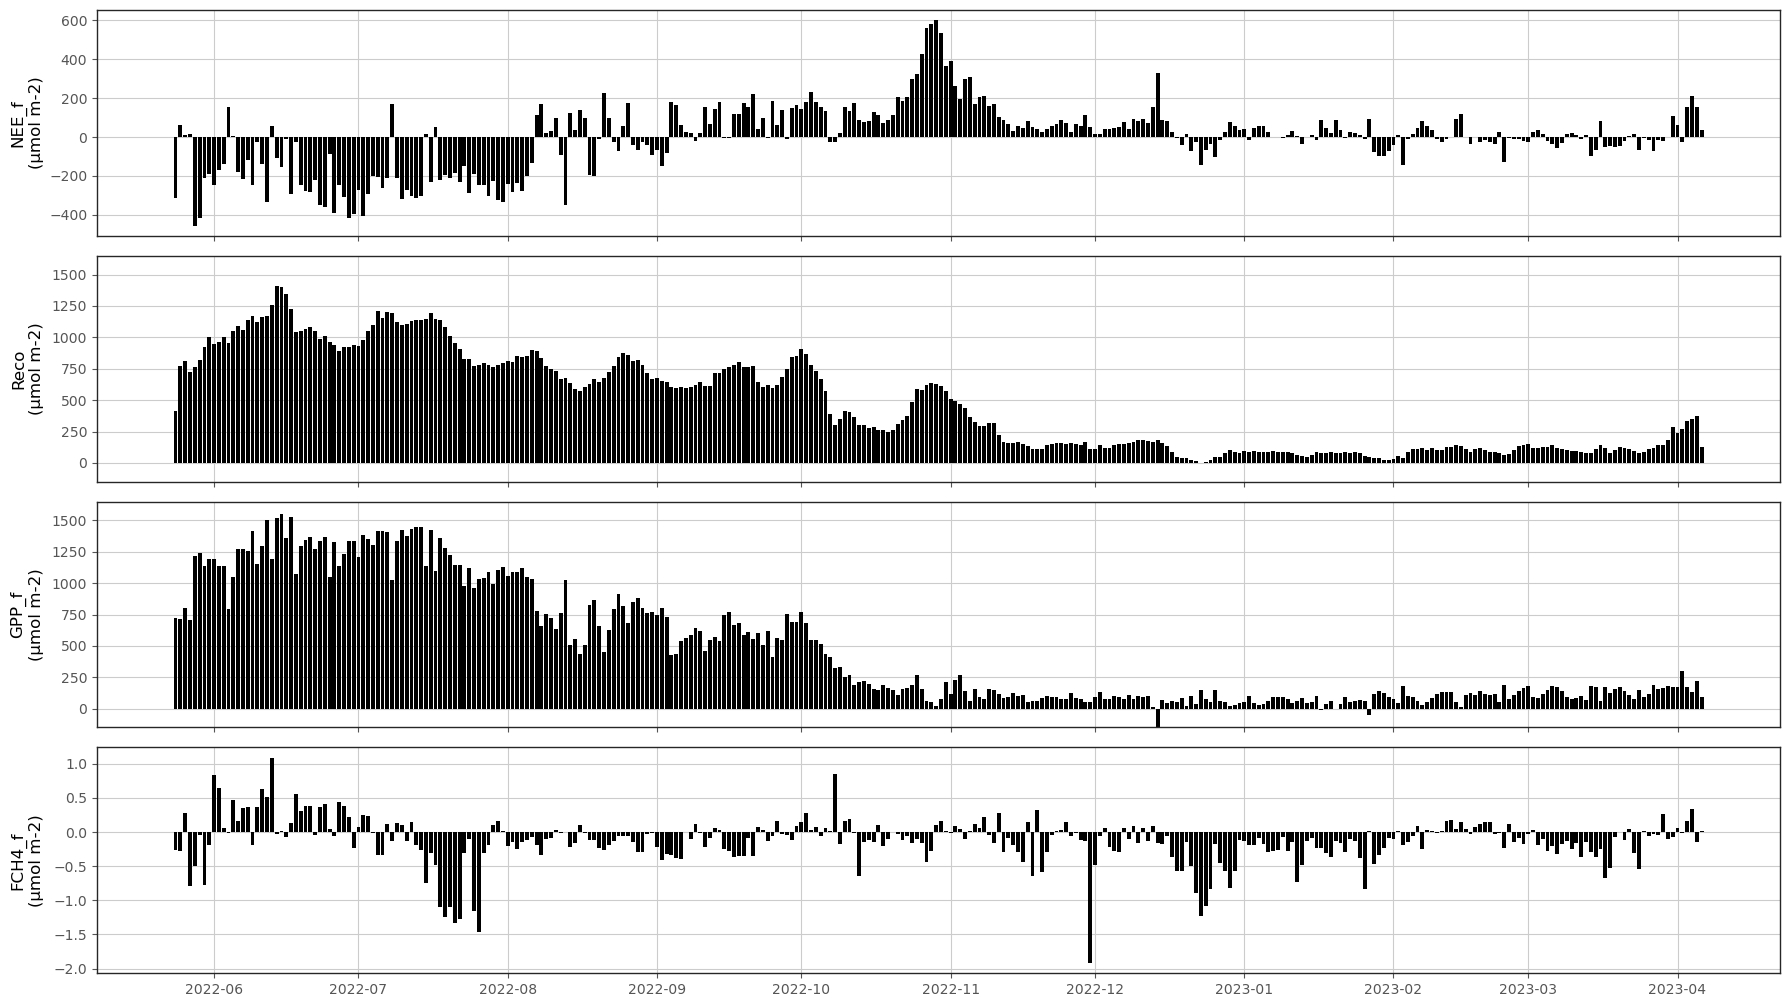

In [57]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')
    
ax[1].set(ylim = [-150,1650])
ax[2].set(ylim = [-150,1650])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_gapfilled.png', dpi=300)


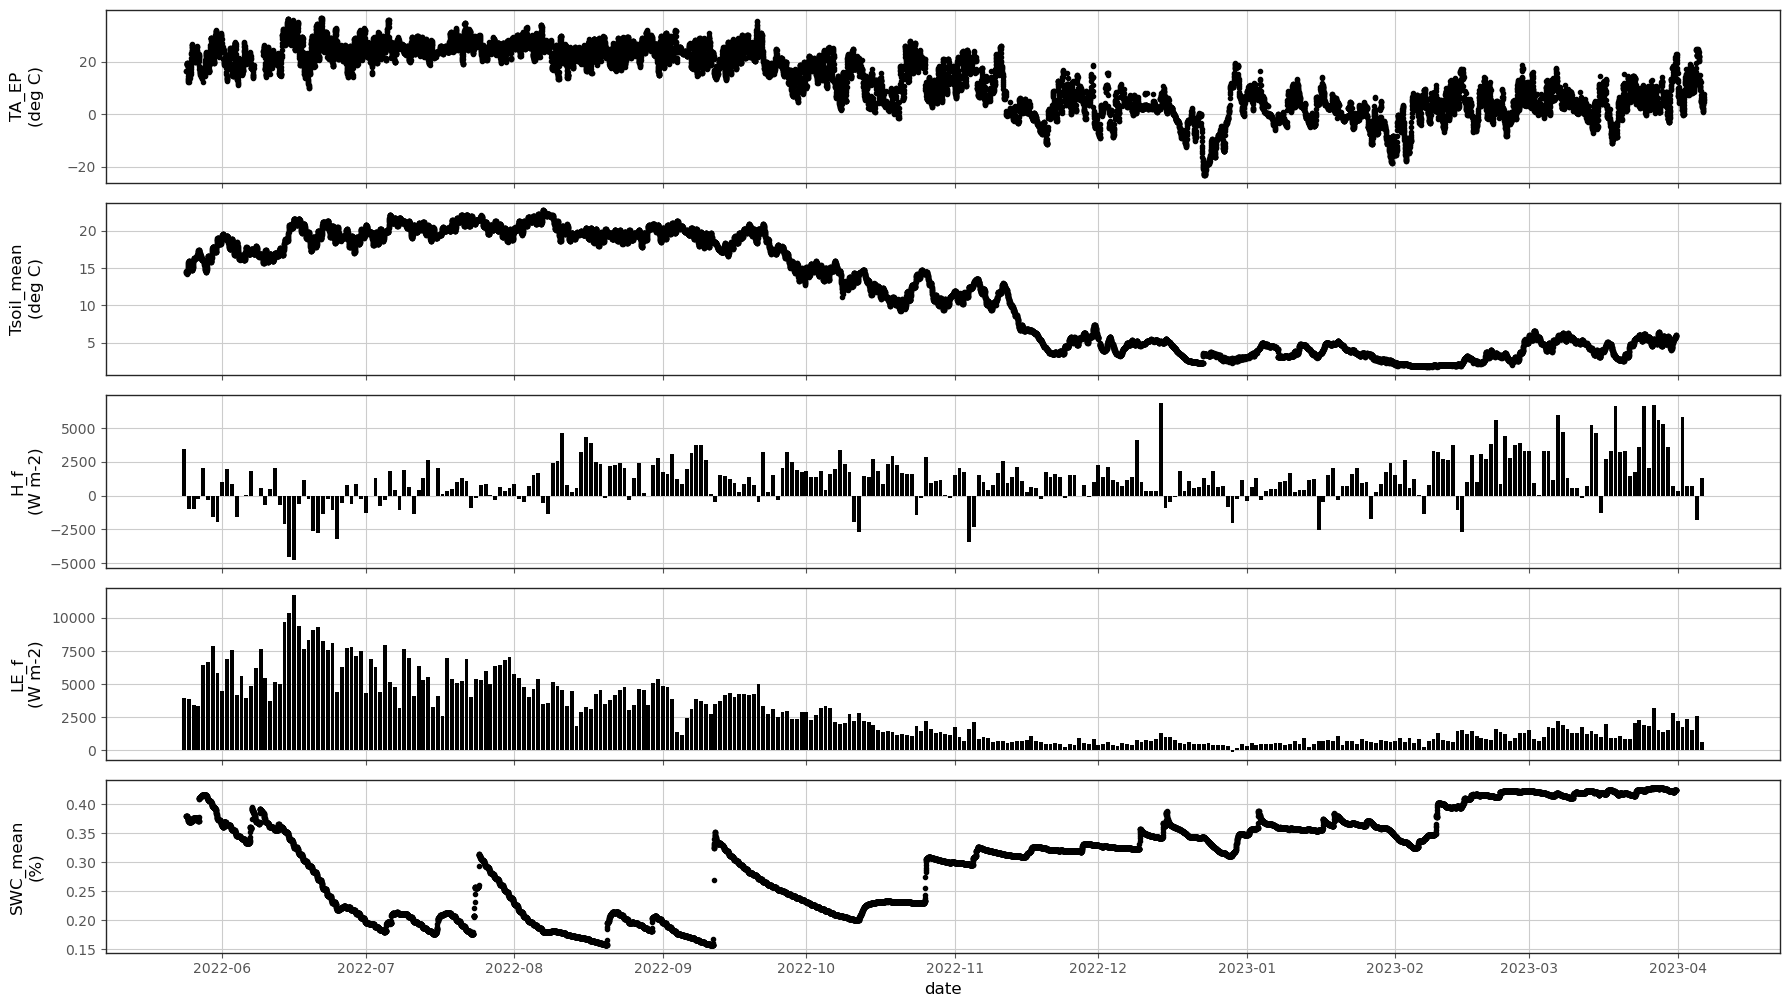

In [58]:
cols = ['TA_EP', 'Tsoil_mean', 'H_f', 'LE_f', 'SWC_mean']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].bar(dailysum.index, dailysum[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].plot(l3[cols[4]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(deg C)')
ax[2].set(ylabel = cols[2] + '\n(W m-2)')
ax[3].set(ylabel = cols[3] + '\n(W m-2)')
ax[4].set(ylabel = cols[4] + '\n(%)', xlabel = 'date')

plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3met_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

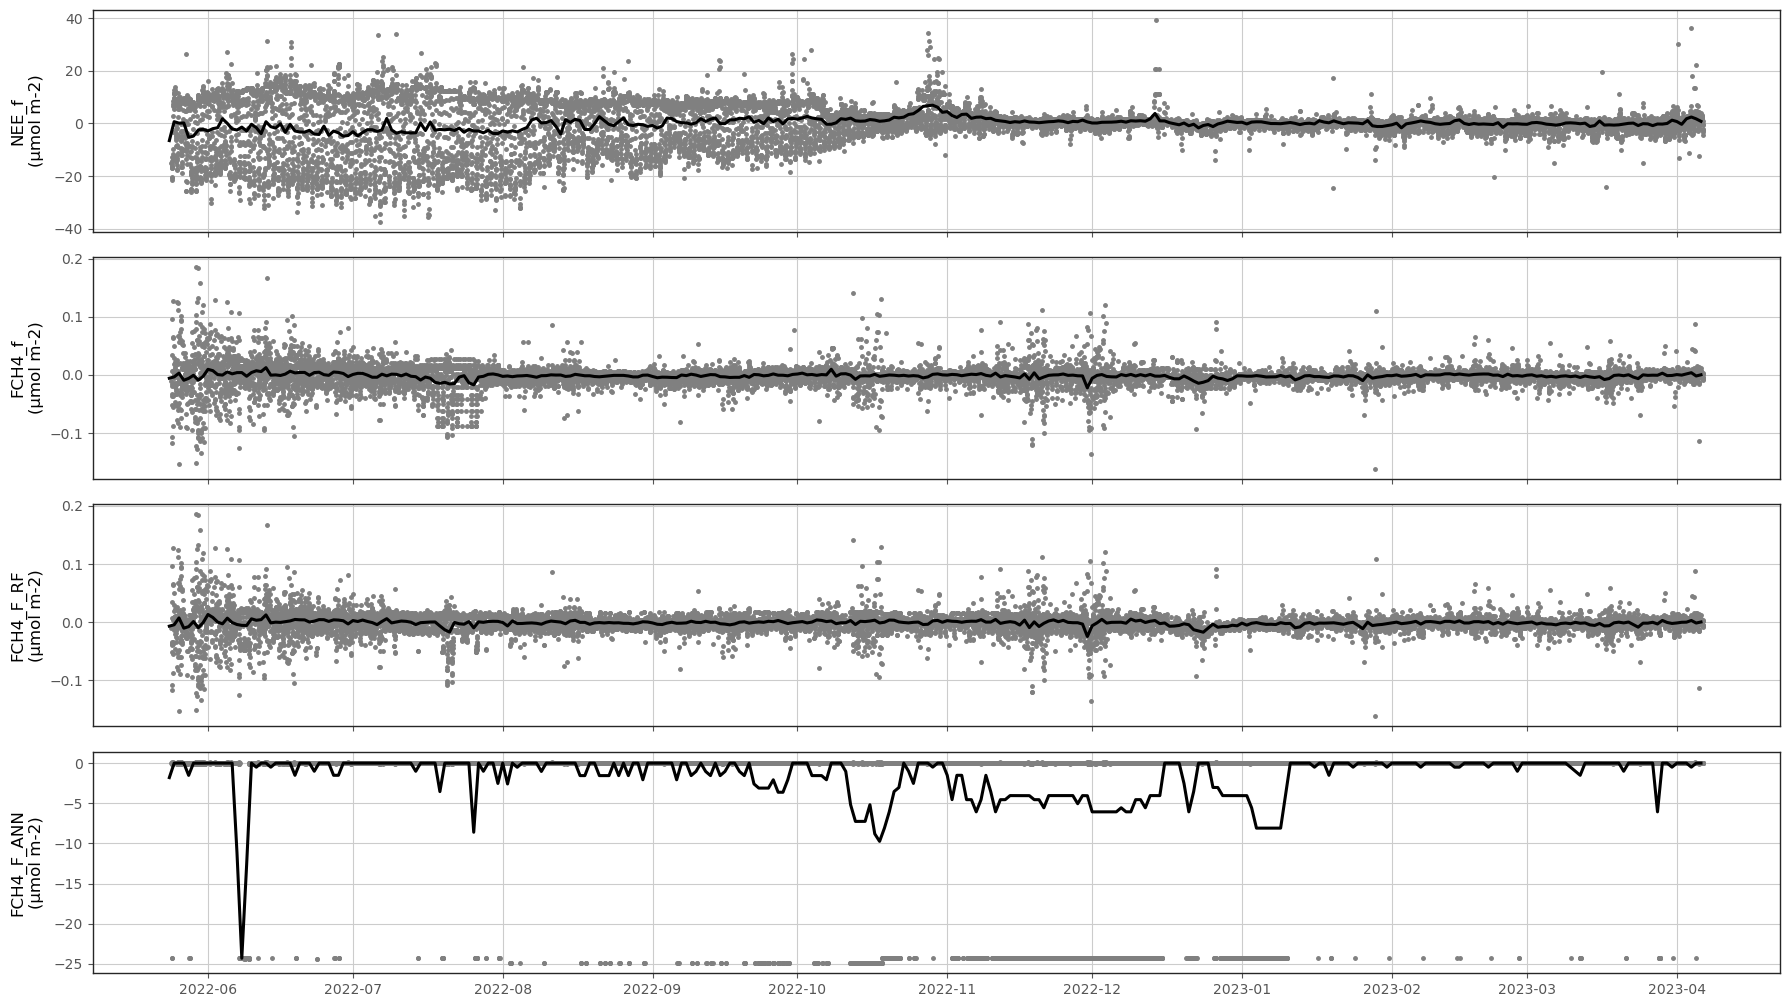

In [61]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].plot(l3[cols[i]], alpha = 1, ms = 5, ls = '', color = 'gray')
    ax[i].plot(daily[cols[i]], marker = '', lw = 2.2, color = 'k')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')


# ax[3].set(ylim=[-1000, 1000])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4models.png', dpi=300)


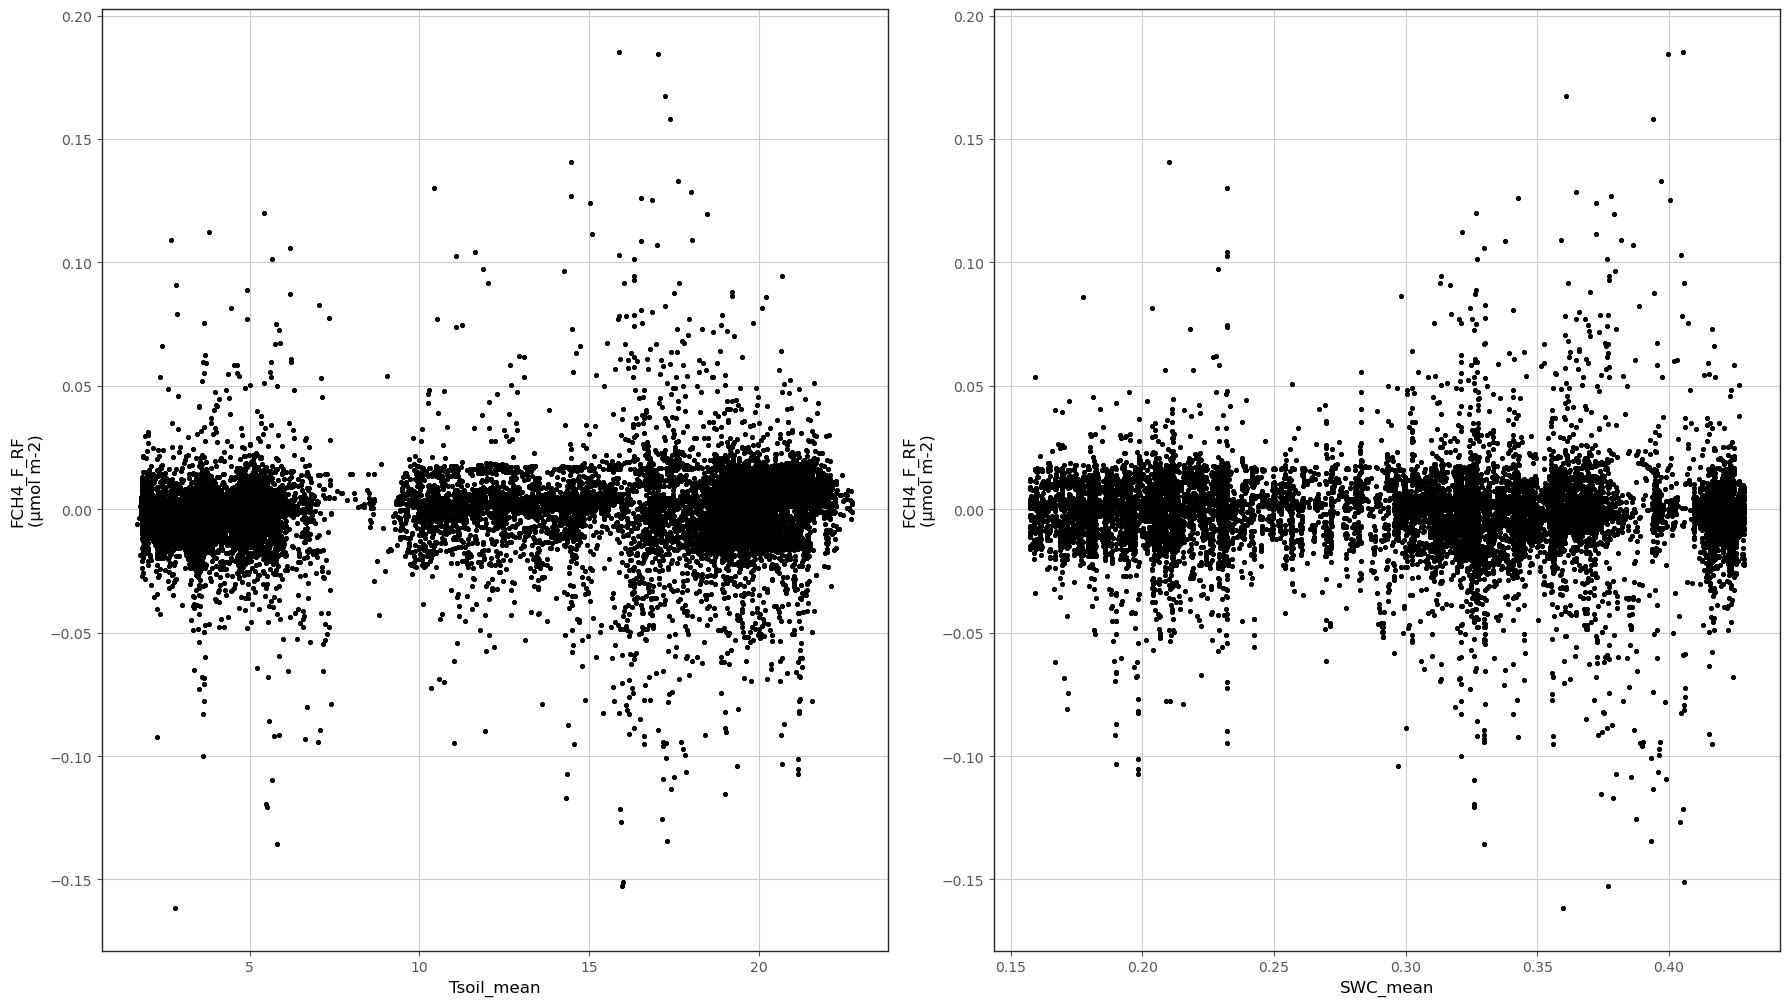

In [104]:
# cols = ['NEE_f', 'LE_f' 'FCH4_f', 'FCH4_F_RF']
cols = ['Tsoil_mean', 'SWC_mean']
fluxes = ['FCH4_f', 'FCH4_F_RF']
flux = fluxes[1]
fig, ax = plt.subplots(1,2)


for i in range(len(ax)):
    ax[i].plot(l3[cols[i]], l3[flux], ms = 5, ls='', color = 'k')
    ax[i].plot(l3[cols[i]], l3[flux], ms = 5, ls='', color = 'k')
    ax[i].set(xlabel = cols[i], ylabel = flux + '\n(µmol m-2)')
plt.tight_layout()
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_{flux}vsTsoilSWC.png', dpi=300)

<AxesSubplot:xlabel='Tsoil_mean', ylabel='SWC_mean'>

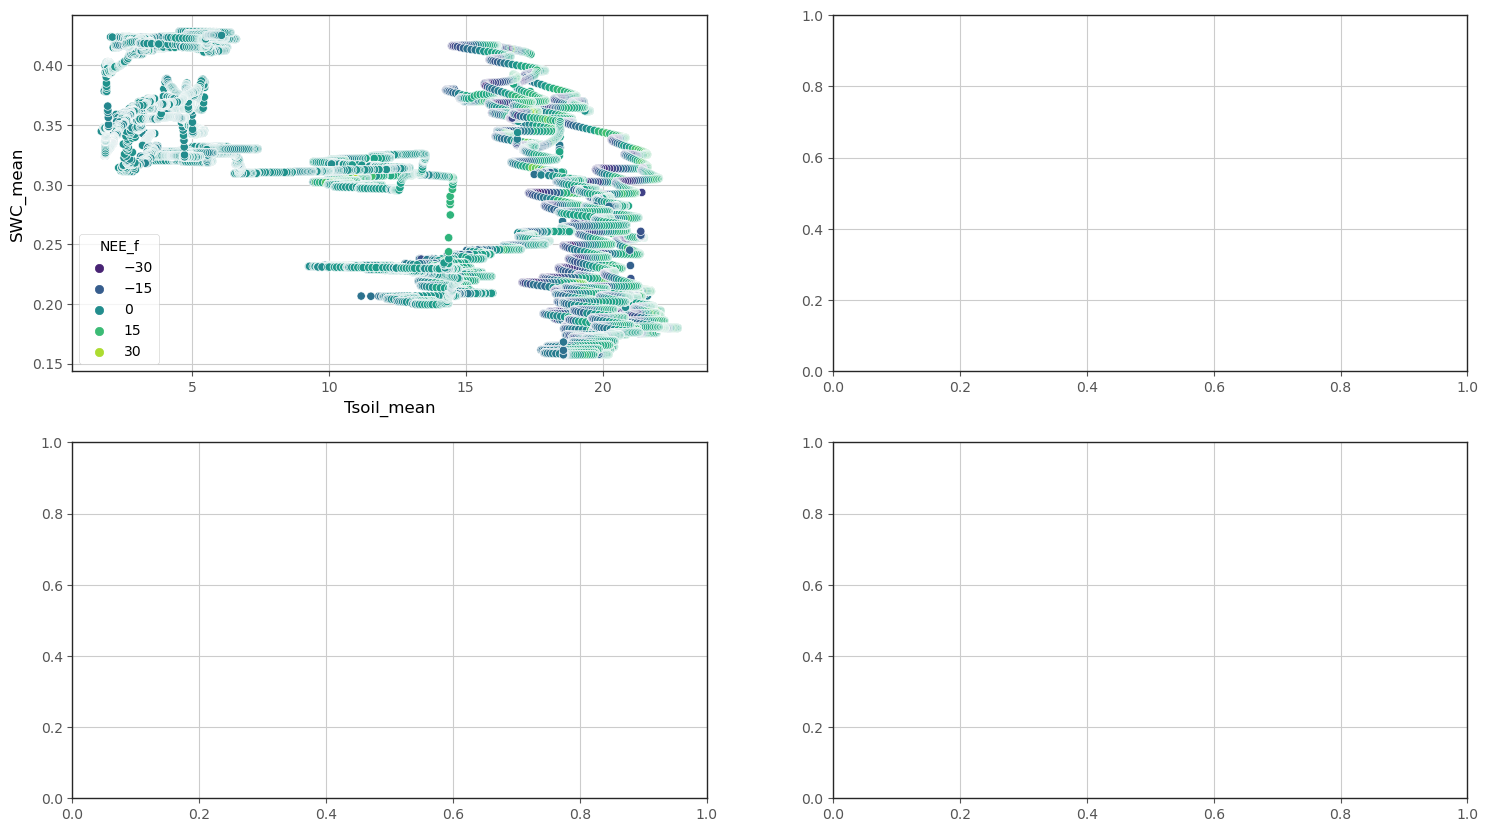

In [82]:
cols = ['NEE_f', 'LE_f' 'FCH4_f', 'FCH4_F_RF']

fig, ax = plt.subplots(2,2)

sns.scatterplot(data=l3, x = 'Tsoil_mean', y = 'SWC_mean', hue = cols[0], palette = 'viridis', ax = ax[0,0])

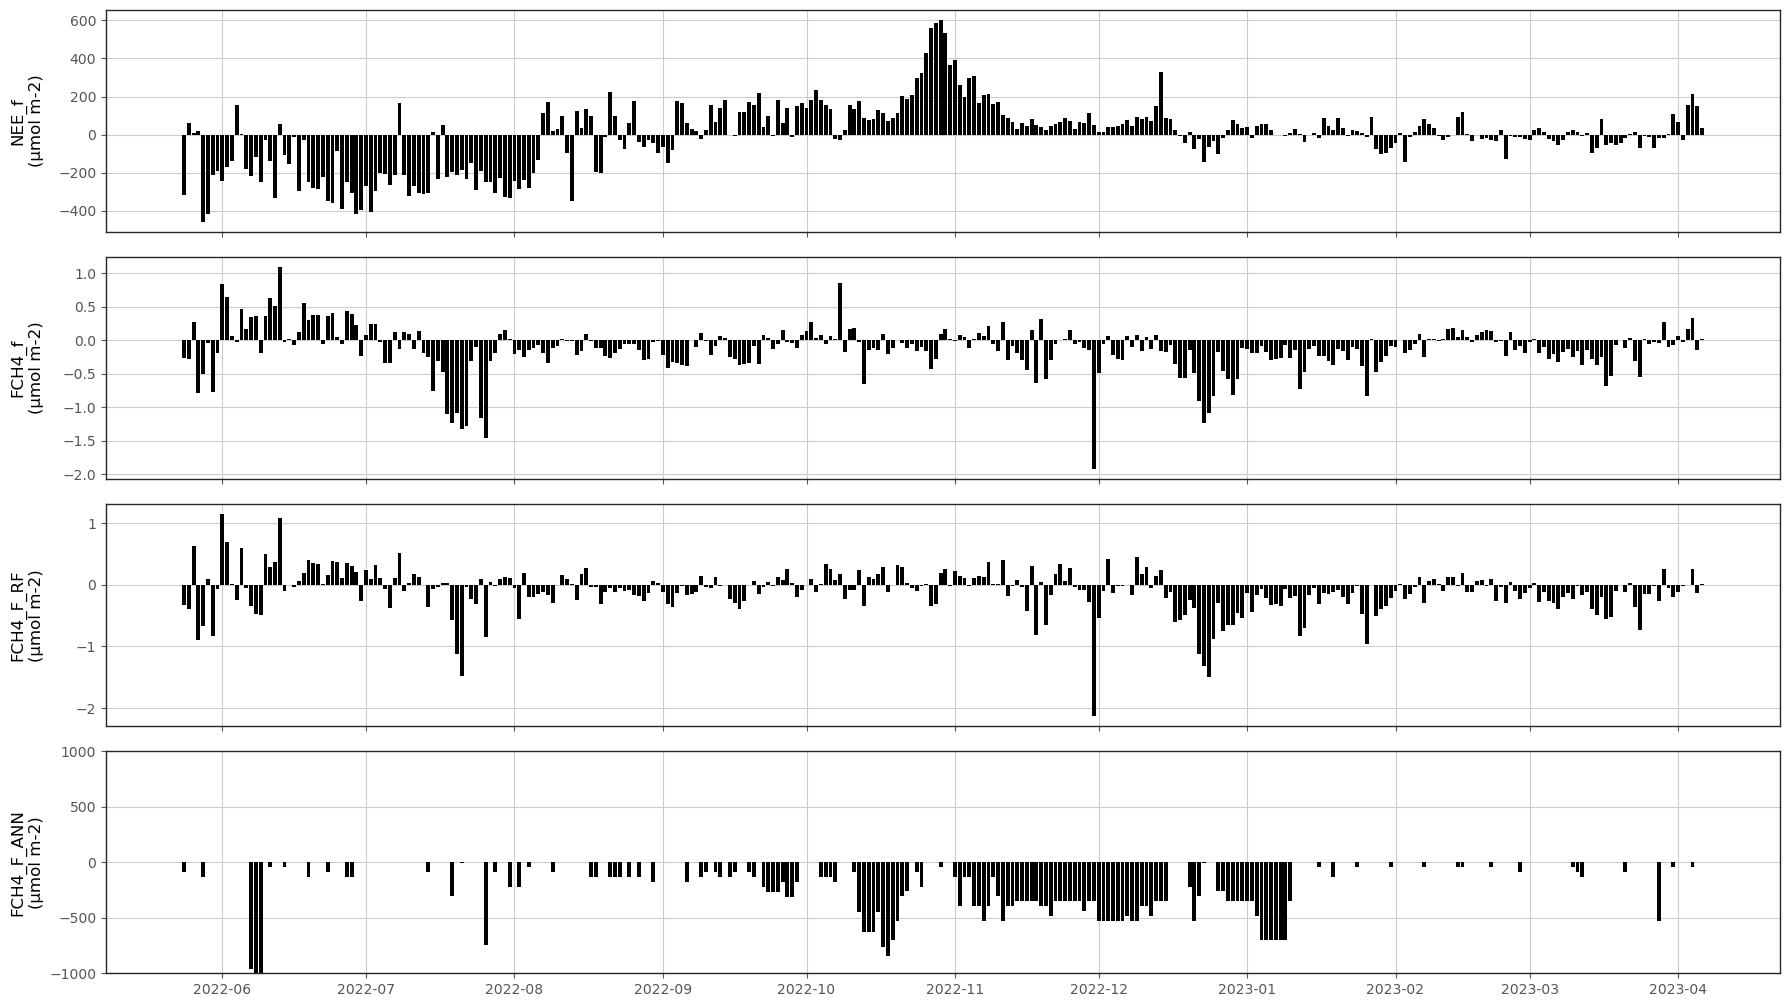

In [60]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')

ax[3].set(ylim=[-1000, 1000])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4modelsums.png', dpi=300)


## Plot methane-gapfill test results

In [8]:
project = 'ATMOS_20230425'

# predictors = ['baseline','basemet','basesoil','baseflux','basemetsoil','basefluxsoil','all']
predictors = ['baseline','basemet','basesoil','baseflux','basefluxvar', 'basemetsoil','basefluxsoil','all'] #0422
labels = ['baseline','+met','+soil','+flux', '+fluxvar', '+metsoil','+fluxsoil','all']

# predictors = ['baseline','basemet','basesoil','baseflux','basefluxvar'] #0425 for now
# labels = ['baseline','+met','+soil','+flux', '+fluxvar']

models = ['ann', 'rf']

tests = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/test_results.csv').assign(pred_subset = subset) for model in models for subset in predictors],
              ignore_index = True)

training = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/training_results.csv').assign(pred_subset = subset, model = model) for model in models for subset in predictors],
                    ignore_index = True)

# training[training['model']=='ann'].boxplot(column = ['nmae', 'pr2'], by='pred_subset')

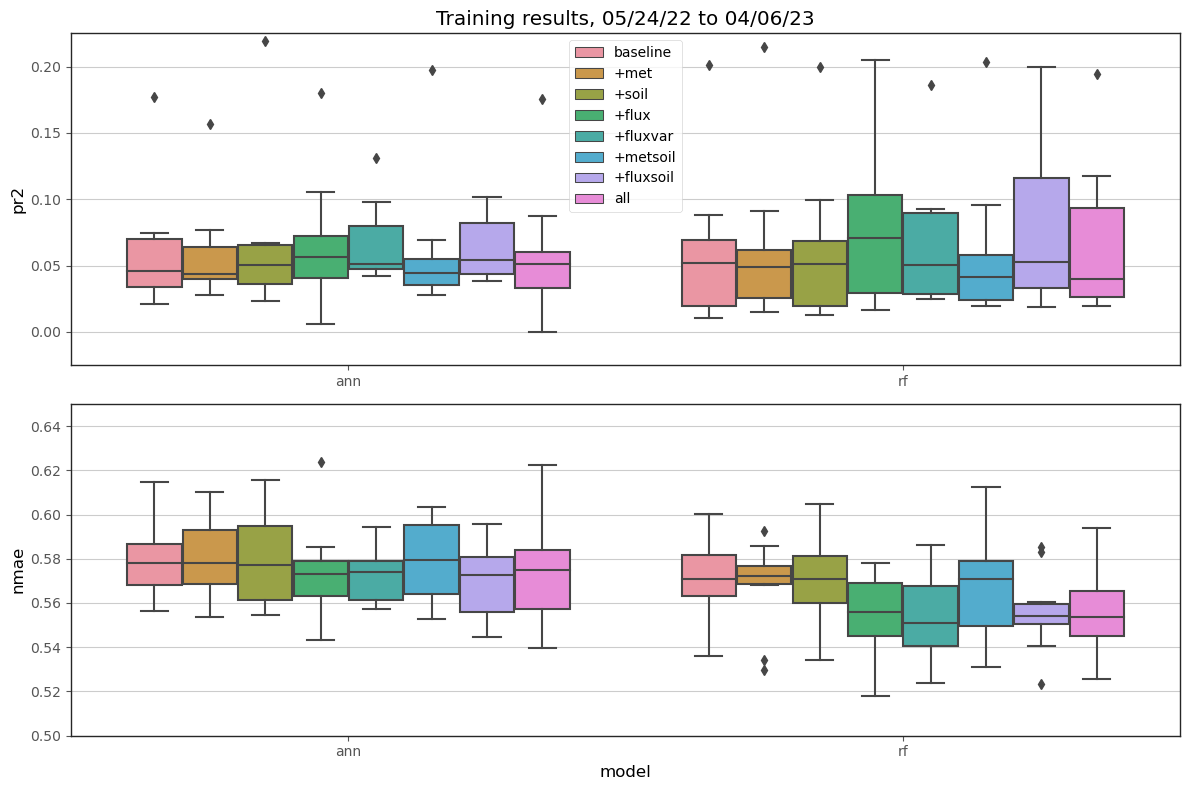

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(x='model', y='pr2', hue='pred_subset', data = training, ax = ax[0])
sns.boxplot(x='model', y='nmae', hue='pred_subset', data = training, ax = ax[1])

ax[1].get_legend().remove()
ax[0].set(ylim = [-0.025, 0.225], xlabel = '', title = 'Training results, 05/24/22 to 04/06/23')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles=h, labels=labels, loc='upper center')
ax[1].set(ylim = [0.5,0.65])
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_training0425.png', dpi=300)

/tmp/ipykernel_3152/3151985919.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
/tmp/ipykernel_3152/3151985919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)
/tmp/ipykernel_3152/3151985919.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels)


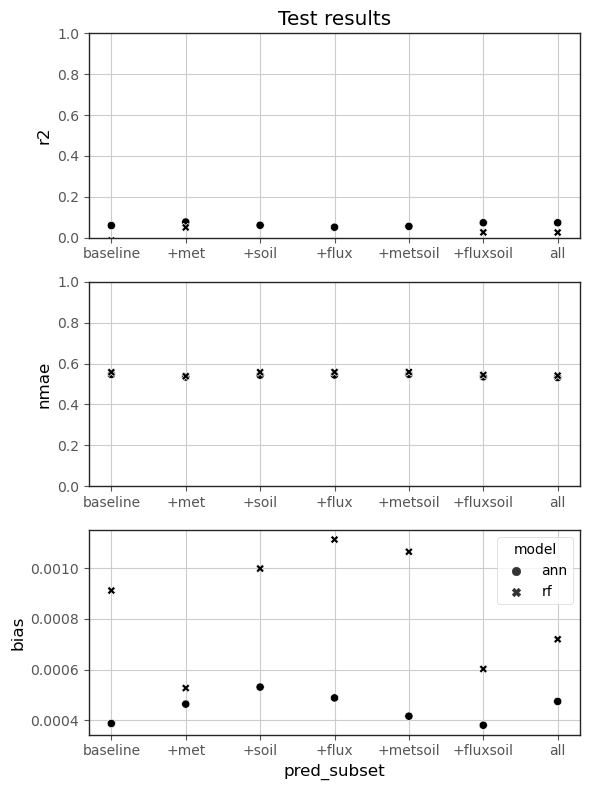

In [6]:
fig, ax = plt.subplots(3,1,figsize = (6, 8))
sns.scatterplot(x='pred_subset',y='r2',style='model', color = 'k', data = tests, ax = ax[0])
sns.scatterplot(x='pred_subset',y='nmae',style='model', color = 'k', data = tests, ax = ax[1])
sns.scatterplot(x='pred_subset',y='bias',style='model', color = 'k', data = tests, ax = ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set(ylim = [0,1], xlabel = None, title = 'Test results')
ax[1].set(ylim = [0,1], xlabel = None)
# ax[2].set(ylim = [0,1])
ax[0].set_xticklabels(labels)
ax[1].set_xticklabels(labels)
ax[2].set_xticklabels(labels)
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_tests.png', dpi=300)

In [87]:
mask1 = l3.columns.str.contains('G_')
mask2 = l3.columns.str.contains('RATIO')
mask3 = l3.columns.str.contains('LAG')
mask4 = l3.columns.str.contains('WD')
l3[l3.columns[mask4]]

WD_FILTER_NR        WD  WD_SIGMA  WD_FILTER_NREX   WD60  \
date                                                                           
2022-05-24 13:30:00       18000.0  247.8900   38.4218             0.0   89.0   
2022-05-24 14:00:00       18000.0  253.6240   31.8325             0.0    NaN   
2022-05-24 14:30:00       18000.0  249.2380   30.6542             0.0  777.7   
2022-05-24 15:00:00       18000.0  253.4170   29.3374             0.0    NaN   
2022-05-24 15:30:00       18000.0  249.4370   34.7957             0.0   60.9   
...                           ...       ...       ...             ...    ...   
2022-11-30 22:00:00           NaN       NaN       NaN             NaN    NaN   
2022-11-30 22:30:00       18000.0   83.6459   16.4263             0.0  285.6   
2022-11-30 23:00:00       18000.0   80.8154   16.0334             0.0    NaN   
2022-11-30 23:30:00       18000.0   76.7809   14.5354             0.0  277.4   
2022-12-01 00:00:00       18000.0   77.0120   13.9002             0.0  274.0   

                     WD_STD60   WD10  WD_STD10  
date                                            
2022-05-24 13:30:00       0.0   63.2      28.9  
2022-05-24 14:00:00       NaN    NaN       NaN  
2022-05-24 14:30:00     777.7   72.8      21.9  
2022-05-24 15:00:00       NaN    NaN       NaN  
2022-05-24 15:30:00      13.8   71.1      14.6  
...                       ...    ...       ...  
2022-11-30 22:00:00       NaN    NaN       NaN  
2022-11-30 22:30:00       9.9  283.0      14.1  
2022-11-30 23:00:00       NaN    NaN       NaN  
2022-11-30 23:30:00       9.2  273.6      12.3  
2022-12-01 00:00:00       9.1  273.2      23.6  

[9142 rows x 8 columns]

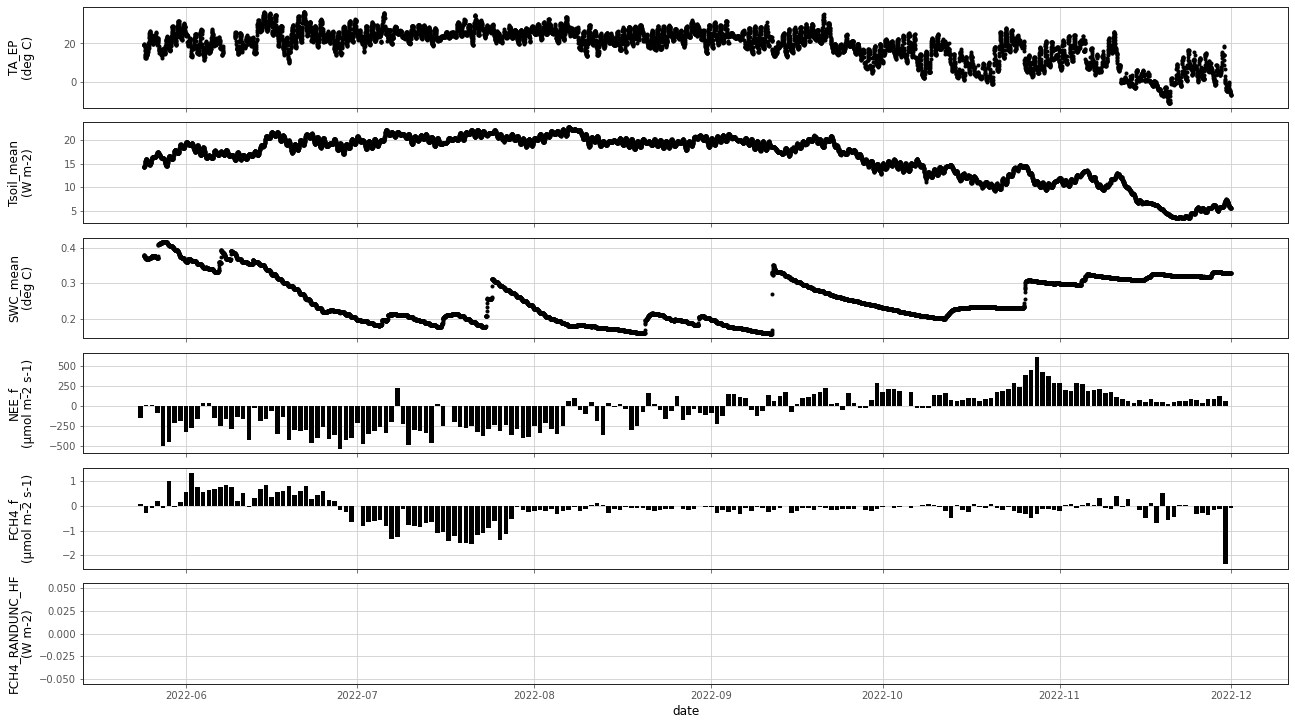

In [7]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'FCH4_RANDUNC_HF']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].plot(l3[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2 s-1)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2 s-1)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)

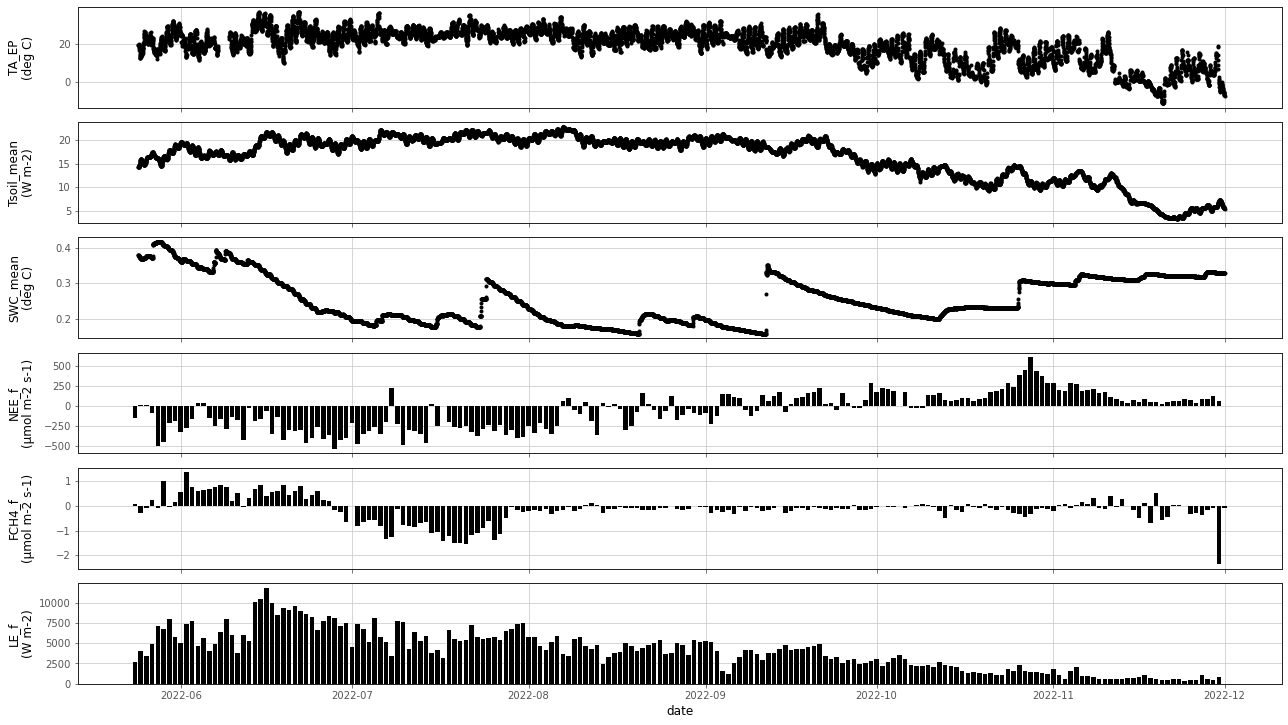

In [4]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'LE_f']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].bar(dailysum.index, dailysum[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)